<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
!pip install catboost

In [2]:
# Импортируем нужные библиотеки
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

import time
from tqdm import tqdm

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error metrics.mean_absolute_error

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import TimeSeriesSplit

from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

In [3]:
RANDOM_STATE = 12345

In [4]:
# Считываем данные из csv-файла в датафрейм и сохраняем в переменной data
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])    
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [5]:
data.sort_index(inplace=True)

In [6]:
print(data.index.is_monotonic)

True


In [7]:
data.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28


In [8]:
# ресемплирование по одному часу
data = data.resample('1H').sum()

In [9]:
data.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71


Данные загружены и проверены. Было произведено ресемлирование по одному часу. Можно приступать к анализу данных.

## Анализ

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.0,54.0,78.0,107.0,462.0


<AxesSubplot:xlabel='datetime'>

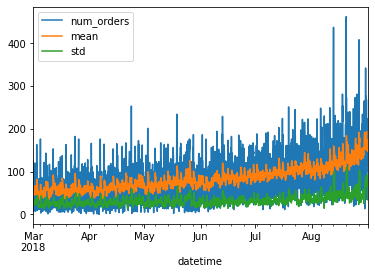

In [11]:
data_plt = data.copy()
data_plt['mean'] = data_plt['num_orders'].rolling(15).mean()
data_plt['std'] = data_plt['num_orders'].rolling(15).std()

data_plt.plot() 

Как видно из графика наблюдается тренд на повышение числа заказов. Рассмотрим отдельно трендовую, сезонную составляющие и остаток декомпозиции.

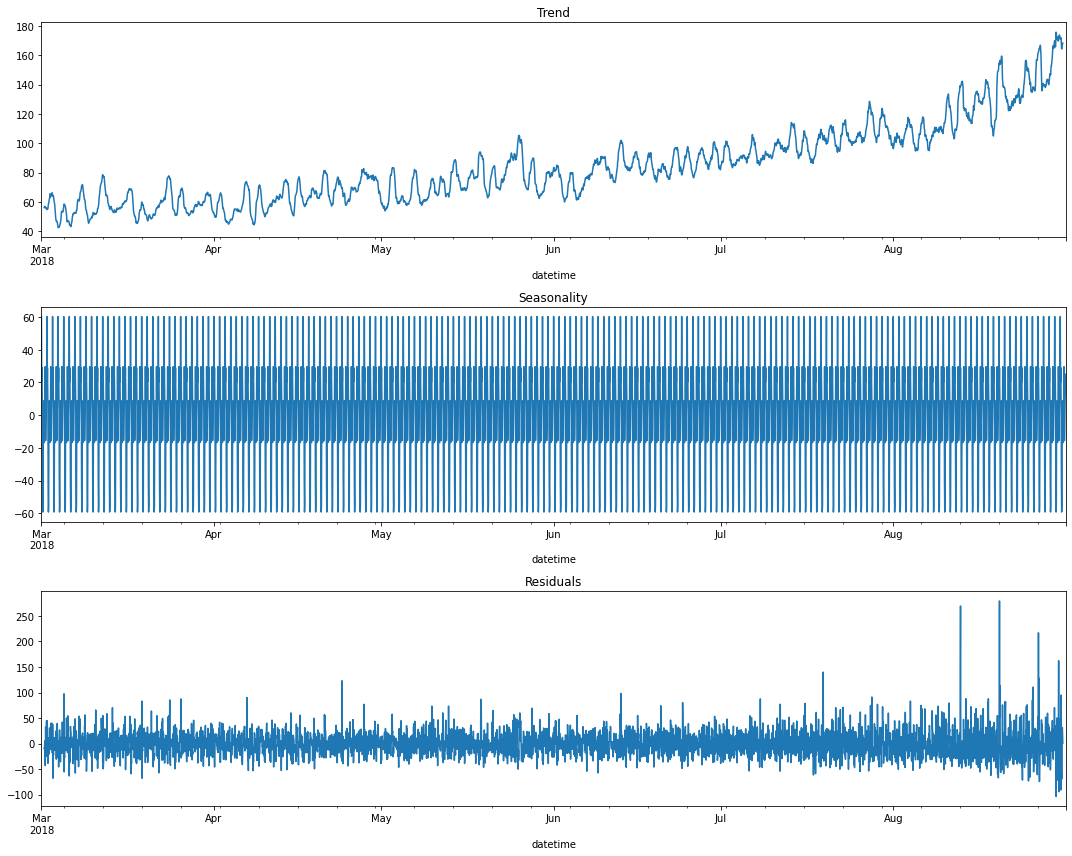

In [12]:
decomposed = seasonal_decompose(data) 

plt.figure(figsize=(15, 12))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<AxesSubplot:xlabel='datetime'>

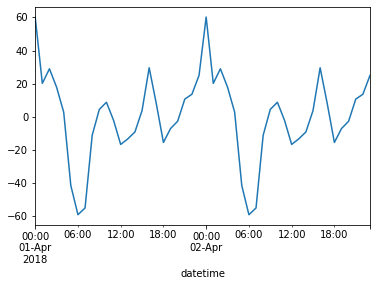

In [13]:
decomposed.seasonal['2018-04-01':'2018-04-02'].plot()

<AxesSubplot:xlabel='datetime'>

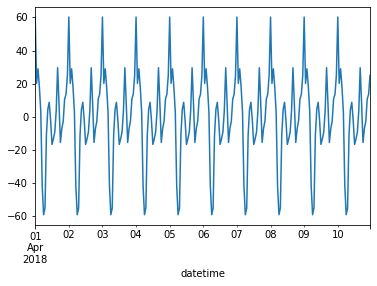

In [14]:
decomposed.seasonal['2018-04-01':'2018-04-10'].plot()

Как видно сезонная составляющая представляет собой стационарный временной ряд. Наблюдаются минимум числа заказов утром в  часов, максимум числа заказов в полночь. Приступим к обучению модели прогнозирования количества заказов такси на следующий час 

## Обучение

In [15]:
model_names = ['Linear', 'Lasso', 'CatBoost', 'LightGBM', 'ARIMA']
model_scores = []

In [16]:
def make_features(dataset, column_name, max_lag, rolling_mean_size):
    dataset['year'] = data.index.year
    dataset['month'] = data.index.month
    dataset['day'] = data.index.day
    dataset['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        dataset['lag_{}'.format(lag)] = dataset[column_name].shift(lag)

    dataset['rolling_mean'] = dataset[column_name].shift().rolling(rolling_mean_size).mean()
    return dataset

In [17]:
def split(dataset):    
    train, valid_test = train_test_split(dataset, shuffle=False, test_size=0.2, random_state=RANDOM_STATE)
    test, valid = train_test_split(valid_test, shuffle=False, test_size=0.5, random_state=RANDOM_STATE)
    
    train = train.dropna()
    features_train = train.drop(['num_orders'], axis=1)
    target_train = train['num_orders']
    features_valid = valid.drop(['num_orders'], axis=1)
    target_valid = valid['num_orders']    
    features_test = test.drop(['num_orders'], axis=1)
    target_test = test['num_orders']
    return features_train, target_train, features_valid, target_valid, features_test, target_test

In [18]:
def find_min_element(matrix):
    min_value = np.min(matrix)
    min_indices = np.where(matrix == min_value)
    min_coordinates = list(zip(min_indices[0], min_indices[1]))
    return min_coordinates

In [19]:
size = 30

data_linear = data.copy()
rmse_train_linear = np.zeros((size, size))
rmse_valid_linear = np.zeros((size, size))

for i in tqdm(range(1, size+1), desc='Подбор параметров'):
    for j in range(1, size+1):
        data_model = make_features(data_linear, 'num_orders', i, j)
        features_train, target_train, features_valid, target_valid, features_test, target_test = split(data_model)
        model = LinearRegression()
        model.fit(features_train, target_train)
        predictions_train = model.predict(features_train)
        predictions_valid = model.predict(features_valid)
        rmse_train_linear[i-1, j-1] = mean_squared_error(target_train, predictions_train, squared=False)
        rmse_valid_linear[i-1, j-1] = mean_squared_error(target_valid, predictions_valid, squared=False)

Подбор параметров: 100%|██████████| 30/30 [03:26<00:00,  6.89s/it]


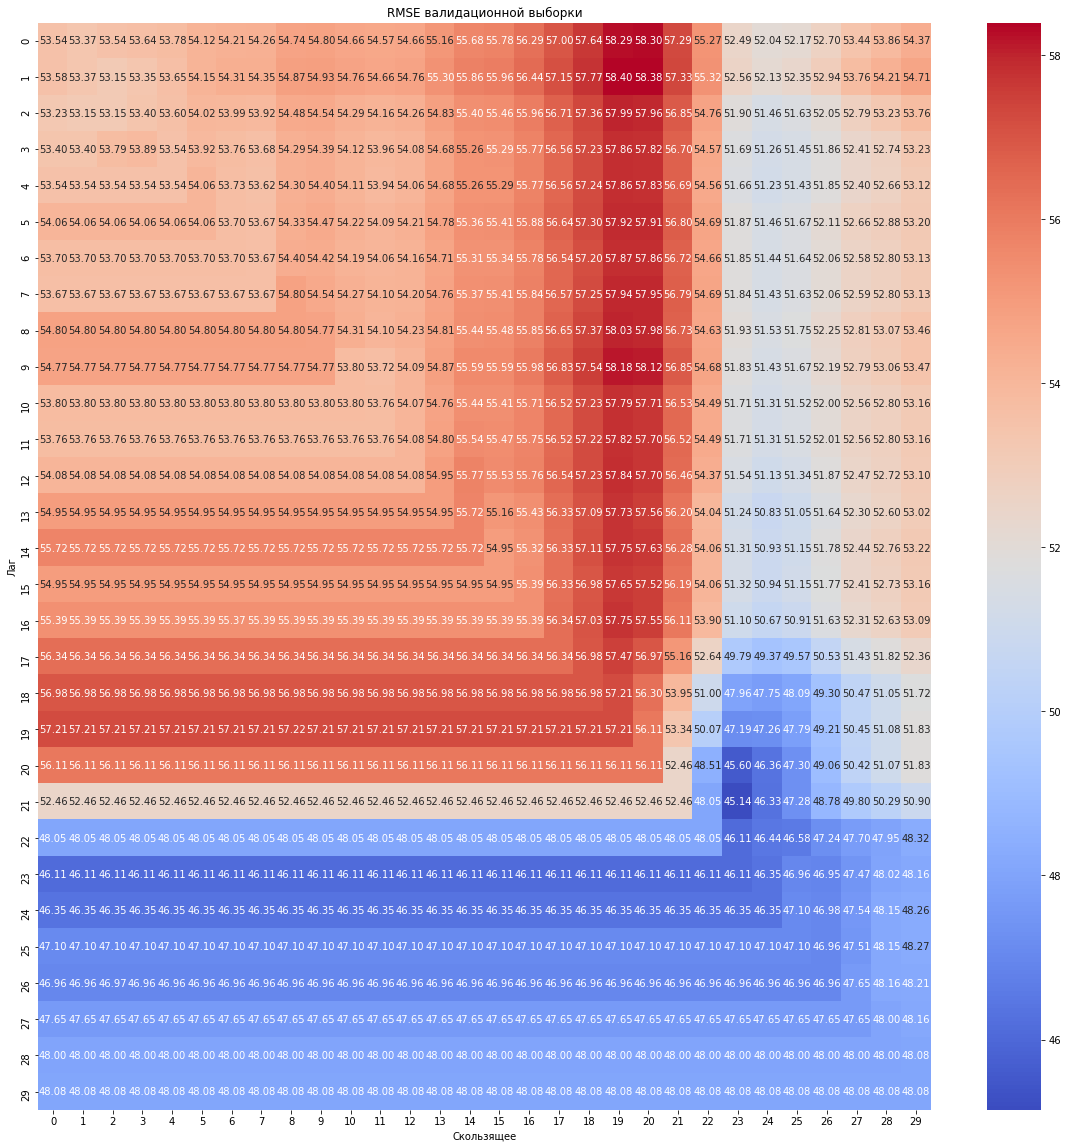

In [20]:
# Создание тепловой карты для RMSE валидационной выборки
plt.figure(figsize=(20, 20))
sns.heatmap(rmse_valid_linear, cmap='coolwarm', annot=True, fmt=".2f", cbar=True)
plt.title('RMSE валидационной выборки')
plt.xlabel('Скользящее')
plt.ylabel('Лаг')
plt.show()

In [21]:
model_scores.append(np.min(rmse_valid_linear))

In [22]:
size = 30

data_lasso = data.copy()
rmse_train_lasso = np.zeros((size, size))
rmse_valid_lasso = np.zeros((size, size))

for i in tqdm(range(1, size+1), desc='Подбор параметров'):
    for j in range(1, size+1):
        data_model = make_features(data_lasso, 'num_orders', i, j)
        features_train, target_train, features_valid, target_valid, features_test, target_test = split(data_model)
        model = Lasso()
        model.fit(features_train, target_train)
        predictions_train = model.predict(features_train)
        predictions_valid = model.predict(features_valid)
        rmse_train_lasso[i-1, j-1] = mean_squared_error(target_train, predictions_train, squared=False)
        rmse_valid_lasso[i-1, j-1] = mean_squared_error(target_valid, predictions_valid, squared=False)

Подбор параметров: 100%|██████████| 30/30 [04:55<00:00,  9.86s/it]


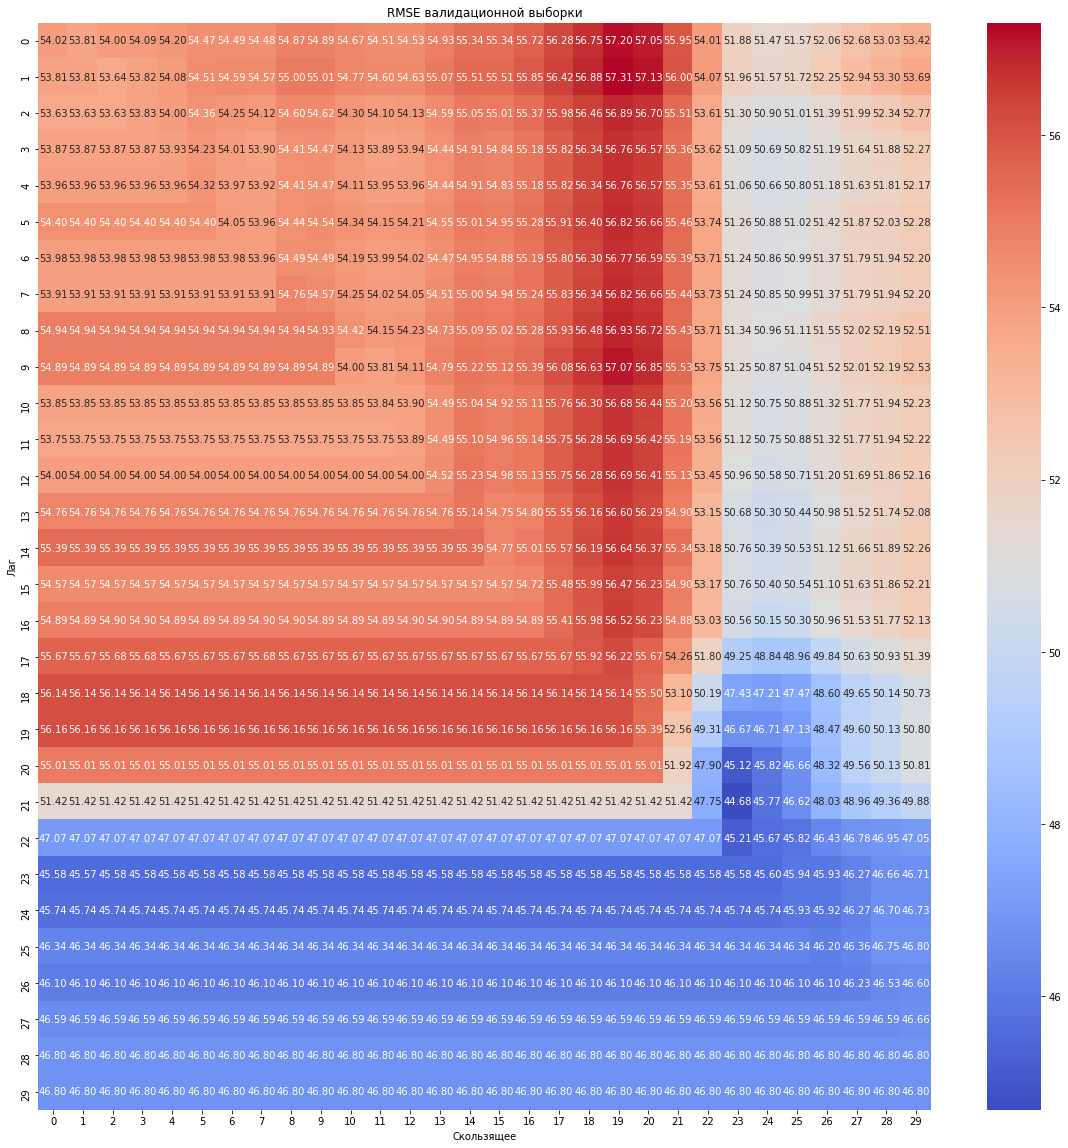

In [23]:
# Создание тепловой карты для RMSE валидационной выборки
plt.figure(figsize=(20, 20))
sns.heatmap(rmse_valid_lasso, cmap='coolwarm', annot=True, fmt=".2f", cbar=True)
plt.title('RMSE валидационной выборки')
plt.xlabel('Скользящее')
plt.ylabel('Лаг')
plt.show()

In [24]:
model_scores.append(np.min(rmse_valid_lasso))

Посомотрим как работают нелинейные модели.

In [25]:
splits = TimeSeriesSplit(n_splits=3)

In [26]:
data_catboost = data.copy()
data_model = make_features(data_catboost, 'num_orders', 25, 25)
features_train, target_train, features_valid, target_valid, features_test, target_test = split(data_model)

catboost = CatBoostRegressor(loss_function='RMSE',random_state = RANDOM_STATE)
parameters_catboost = {'depth':[None, 5, 10], 'learning_rate':np.arange(0.1,1,0.2)}
catboost_grid = catboost.grid_search(parameters_catboost,
            Pool(features_train,target_train),cv=splits,verbose=True)

final_cat = CatBoostRegressor(depth=catboost_grid["params"]["depth"], 
                              learning_rate=catboost_grid["params"]['learning_rate'],
                              loss_function='RMSE',verbose=100)
final_cat.fit(Pool(features_train,target_train))

preds_Cat_valid = final_cat.predict(features_valid)
mean_squared_error(target_valid, preds_Cat_valid, squared=False)

0:	learn: 70.0268990	test: 95.6023162	best: 95.6023162 (0)	total: 52ms	remaining: 52s
1:	learn: 64.2236674	test: 88.6299466	best: 88.6299466 (1)	total: 56ms	remaining: 27.9s
2:	learn: 59.0924037	test: 82.5043995	best: 82.5043995 (2)	total: 59.6ms	remaining: 19.8s
3:	learn: 54.7868471	test: 77.2606539	best: 77.2606539 (3)	total: 63.1ms	remaining: 15.7s
4:	learn: 50.7550493	test: 72.3979881	best: 72.3979881 (4)	total: 66.9ms	remaining: 13.3s
5:	learn: 47.0823582	test: 68.3614753	best: 68.3614753 (5)	total: 72.1ms	remaining: 11.9s
6:	learn: 43.8058643	test: 64.3409997	best: 64.3409997 (6)	total: 77.1ms	remaining: 10.9s
7:	learn: 40.8732338	test: 60.5617679	best: 60.5617679 (7)	total: 82.3ms	remaining: 10.2s
8:	learn: 38.3287366	test: 57.1345366	best: 57.1345366 (8)	total: 86.2ms	remaining: 9.49s
9:	learn: 36.1377018	test: 53.7198121	best: 53.7198121 (9)	total: 89.7ms	remaining: 8.88s
10:	learn: 34.1859347	test: 51.4405901	best: 51.4405901 (10)	total: 93.3ms	remaining: 8.39s
11:	learn: 32.

48.49479078007218

In [27]:
final_cat = CatBoostRegressor(depth=catboost_grid["params"]["depth"], 
                              learning_rate=catboost_grid["params"]['learning_rate'],
                              loss_function='RMSE',verbose=False)
final_cat.fit(Pool(features_train,target_train))
predictions_cat_valid = final_cat.predict(features_valid)

In [28]:
model_scores.append(mean_squared_error(target_valid, predictions_cat_valid, squared=False))

In [29]:
data_LGBM = data.copy()

data_model = make_features(data_LGBM, 'num_orders', 25, 25)
features_train, target_train, features_valid, target_valid, features_test, target_test = split(data_model)
model = LGBMRegressor(random_state = RANDOM_STATE)
model.fit(features_train, target_train)
predictions_train = model.predict(features_train)
predictions_valid = model.predict(features_valid)

In [30]:
model_scores.append(mean_squared_error(target_valid, predictions_valid, squared=False))

In [31]:
# Загрузка датасета
data_arima = data.copy()

# Разделение на тренировочную, валидационную и тестовую выборки
train_size = int(len(data_arima) * 0.8)
valid_size = int(len(data_arima) * 0.1)
train, valid, test = data_arima[:train_size], data_arima[train_size:train_size+valid_size], data_arima[train_size+valid_size:]

# Создание модели ARIMA
model_arima = ARIMA(train['num_orders'], order=(21, 5, 23))
model_arima_fit = model_arima.fit()

# Получение прогнозов для обучающей и валидационной выборок
predictions_train = model_arima_fit.predict(start=train.index[0], end=train.index[-1])
predictions_valid = model_arima_fit.predict(start=valid.index[0], end=valid.index[-1])

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [32]:
model_scores.append(mean_squared_error(valid['num_orders'], predictions_valid, squared=False))

## Тестирование

In [33]:
results = pd.DataFrame([model_names, model_scores]).T
results.columns = ['model', 'RMSE_valid']

In [34]:
results

,model,RMSE_valid
0,Linear,45.142894
1,Lasso,44.679876
2,CatBoost,48.494791
3,LightGBM,53.727367
4,ARIMA,441523.03437


Из расмотренных моделей выбираем модель Lasso. Найдем значение RMSE на тестовой выборке и равним выбранную модель с Dummy моделью, которая будет предсказывать следующее значение предыдущим.

In [40]:
lag = find_min_element(rmse_valid_lasso)[0][0]
rolling_mean = find_min_element(rmse_valid_lasso)[0][1]

In [41]:
data_model = make_features(data, 'num_orders', lag, rolling_mean)
features_train, target_train, features_valid, target_valid, features_test, target_test = split(data_model)
model = Lasso()
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)

In [42]:
mean_squared_error(target_test, predictions_test, squared=False)

36.57261628447423

In [43]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

In [44]:
mean_squared_error(target_test, pred_previous, squared=False)

47.246345832986236

Модель успешно прошла проверку на тривиальность и показала метрику ниже минимально установленной.

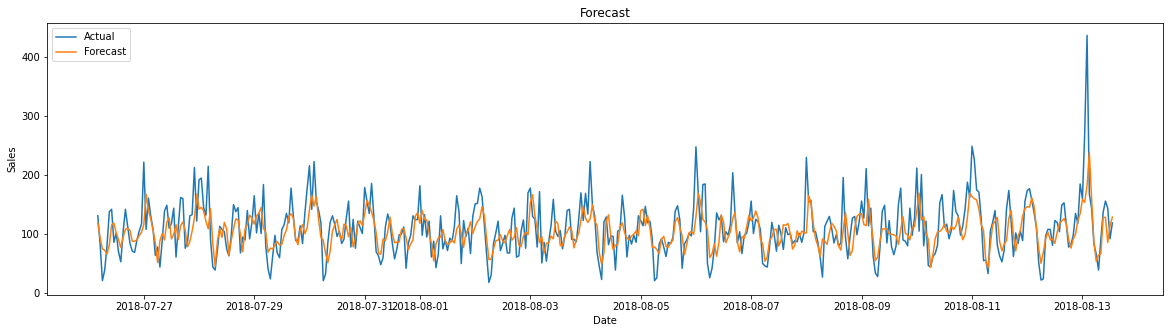

In [56]:
# Визуализация результатов
plt.figure(figsize=(20, 5))
plt.plot(target_test.index, target_test.values, label='Actual')
plt.plot(target_test.index, predictions_test, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Forecast')
plt.legend()
plt.show()

## Вывод

В рамках данного исследования были загружены и изучены исторические данные о заказах такси в аэропортах. Данные были загружены и проверены на корректность. Было произведено ресемлирование по одному часу.  

При анализе данных было выявлено что наблюдается тренд на повышение числа заказов. В данных имеется сезонная цикличность: yаблюдаются минимум числа заказов утром в часов, максимум числа заказов в полночь.  

На тренировочной выборке были обучены модели LinearRegression, Lasso, RandomForestRegressor, LGBMRegressor, CatBoostRegressor, ARIMA. По значению RMSE на валидационной выборке, была выбрана модель Lasso как наиболее перспективная для поставленных заказчиком задач. Значение метрики RMSE на тестовой выборке: 36.57. Выбранная модель была проверена на корректность, сравеннием с Dummy моделью, которая будет предсказывать следующее значение предыдущим. 